On the [puzzlor](http://puzzlor.com/2014-04_SpyCatcher.html) website there is old puzzle that can be solved using Markov Models. The puzzle was posted on April 2014, so the answer and some solutions were already published. This problem will be used to demonstrate usage of Markov Chains and Stochastic Matrices.


[![Open In Colab](../images/badges/colab.svg)](https://colab.research.google.com/github/izikeros/blog/blob/master/content/posts/notebooks/2019-08-10-spy-catch.ipynb)&nbsp;[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/izikeros/blog/master?labpath=content%2Fposts%2Fnotebooks%2F2019-08-10-spy-catch.ipynb)

**Problem to solve**:

>Your government has lost track of a high profile foreign spy, and they have requested your help to track him down. As part of his attempts to evade capture, he has employed a simple strategy. Each day the spy moves from the country that he is currently in to a neighboring country.
>The spy cannot skip over a country (for example, he cannot go from Chile to Ecuador in one day). The movement probabilities are equally distributed amongst the neighboring countries. For example, if the spy is currently in Ecuador, there is a 50% chance he will move to Colombia and a 50% chance he will move to Peru. The spy was last seen in Chile and will only move about countries that are in South America. He has been moving about the countries for several weeks.

![south america map](http://safjan.com/images/spycatcher/spycatcher-map.png)

>Question: Which country is the spy most likely hiding in and how likely is it that he is there?

## Markov chains

Markov's chains are mathematical models used to describe systems that change the state from one to another. For example, you can think of simple weather model with two states "Sunny" and "Rainy" and describe system assigning probabilities of transiting from one state to another and probabilities of staying in the same state.

Another example can be Markov chain model of a baby's behavior, with states: "playing," "eating", "sleeping," and "crying". If you have transition probabilities you can predict e.g., the chance that a baby currently playing will fall asleep in the next five minutes without crying first. For getting the intuition if such model visit: [setosa project - Explained Visually](http://setosa.io/ev/markov-chains/) to see interactive models and visual explanation of Markov Chains.

![Markov Chain Model with two states: 'A' and 'B' and animated transitions between them](http://safjan.com/images/spycatcher/spycatcher-mc-visually-275px.gif)

*Figure 1. Sample process with two states: 'A' and 'B' and transitions between them. Probability of transition for state 'A' to 'B' is much lower than probability of transition from state 'B' to 'A'.Example captured from [Explained Visually](http://setosa.io/ev/markov-chains/)*

## Preparations

Start with importing modules we will use, and configure them.

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# limit pandas display precision for better readability
pd.set_option("precision", 2)

plt.style.use("fivethirtyeight")

## Solution plan

Let's distill important information we are given in the problem statement.
1. We are dealing with transitions between discrete states in a finite state space.
2. The spy's strategy is based on random moves - it is a stochastic process.
3. Description of spy's strategy indicate that this stochastic process is memoryless - history doesn't affect next move of the spy. Only current state counts.

These clued indicate that a Markov chain may be the best way to model the spy's movements.

Let's begin by creating an adjacency matrix for these countries - a matrix that indicates other countries to which the spy could move from any given country. By convention, this matrix is configured row-wise, so that the matrix element $a_{ij}$ represents whether it is possible for the spy to move to country $j$ (the column) from country $i$ (the row).

## Create adjacency matrix

Let's get South American Country names from Wikipedia using pandas *read_html* method to scrape an article:

In [2]:
url = "http://en.wikipedia.org/wiki/List_of_South_American_countries_by_population"
south_america = pd.read_html(url, match="Country")[0]
try:
    countries = sorted((south_america["Country"]["Country"].str.lower())[:13])
    countries[6] = "french guiana"  # shorten original name
    print(countries)
except:
    # use hardcoded names if scrapping fails
    countries = ['argentina', 'bolivia', 'brazil', 'chile', 'colombia', 'ecuador', 'french guiana', 'french guiana', 'guyana', 'paraguay', 'peru', 'suriname', 'uruguay', 'venezuela']

['argentina', 'bolivia', 'brazil', 'chile', 'colombia', 'ecuador', 'french guiana', 'guyana', 'paraguay', 'peru', 'suriname', 'uruguay', 'venezuela']


and describe adjacency (country neighbourhood):

In [3]:
# the rows/cols are for the countries in alphabetical order
adjacency = np.array(
    [
        [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    ]
)

# sanity check if adjacency matrix is symmetric
assert np.all(adjacency.T == adjacency)

The adjacency matrix can be turned into graph using *networkx* module.

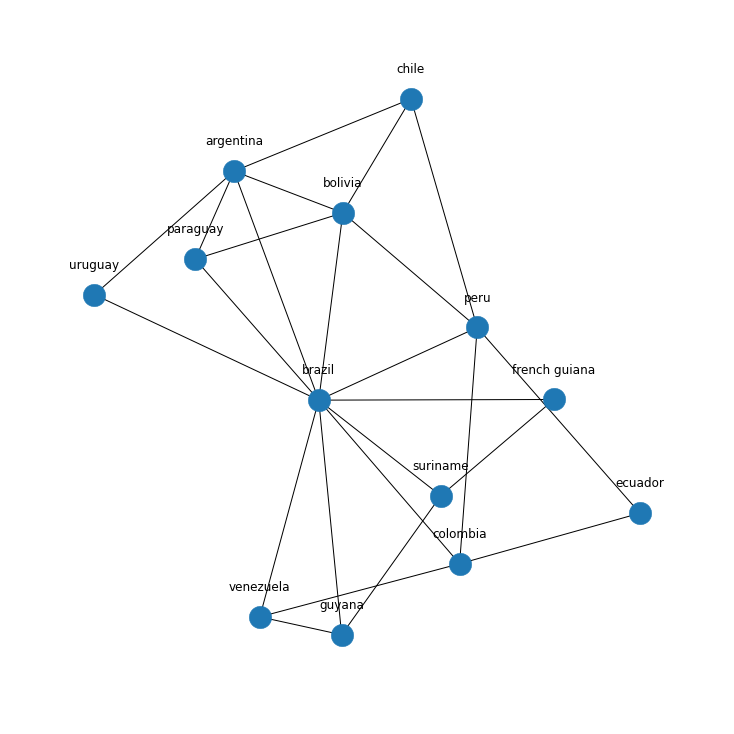

In [4]:
np.random.seed(0)
fig = plt.figure(figsize=(10, 10))


def make_label_dict(labels):
    l = {}
    for i, label in enumerate(labels):
        l[i] = label
    return l


G = nx.Graph(adjacency)

labels = make_label_dict(countries)

# layout the graph
pos = nx.spring_layout(G)

# draw graph
ax = nx.draw(G, pos, node_size=500, with_labels=False)

# draw node labels
for p in pos:  # raise text positions
    pos[p][1] += 0.10
nx.draw_networkx_labels(G, pos, labels=labels)
f = 0.1
x = plt.xlim()[1] - plt.xlim()[0]
y = plt.ylim()[1] - plt.ylim()[0]
plt.xlim(plt.xlim()[0] - f * x, plt.xlim()[1] + f * x)
plt.ylim(plt.ylim()[0] - f * x, plt.ylim()[1] + f * x)
plt.show()

*Figure 2. Neighbouring relations visualized as graph created from adjacency matrix*

## Calculate stochastic matrix (transition matrix)

Now that we have figured out which countries are adjacent (that is, which other countries the spy could feasibly move to from each country), we can turn that into a stochastic matrix $A$ (also called the transition matrix) representing how likely each transition is conditioned on the spy being in a certain country.

In other words, we are normalizing the row vectors so that they represent probabilities, which is very easy in this problem because the spy is equally likely to move to any of the adjacent countries. That means we can normalize each row just by dividing it by its sum. To be concrete, we are taking each row of the adjacency matrix such as this one showing the countries we could move to from Argentina:

In [5]:
adjacency[0, :]

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0])

Using the knowledge that each adjacent country is an equally likely transition, we are turning this binary row of possibilities into a probability mass function of probabilities representing chance of being in each of the adjacent countries in the subsequent day:

In [6]:
A = adjacency.astype(float)

# normalize by row
for i in range(len(adjacency)):
    A[i, :] /= A[i, :].sum()

np.set_printoptions(precision=2)
pd.DataFrame(A).style.background_gradient(cmap="Blues", axis=1)

*Table 1. Transition matrix - value in each matrix element $a_{ij}$ represents probability that the spy will move to country $j$ (the column) from country $i$ (the row).*


We can add these probabilities to our graph representation of the model:

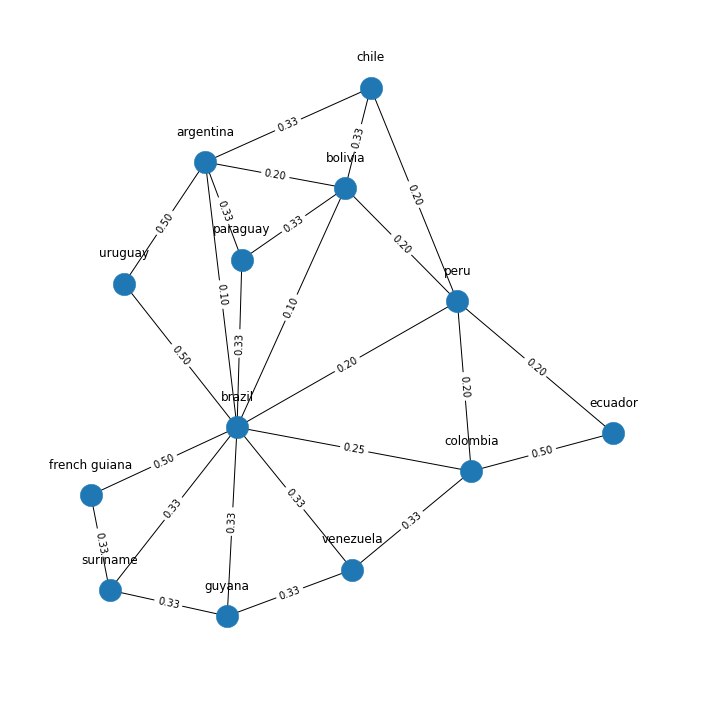

In [7]:
np.random.seed(0)
fig = plt.figure(figsize=(10, 10))

G = nx.Graph(A)

edge_labels = dict(((u, v), f'{d["weight"]:.2f}') for u, v, d in G.edges(data=True))

# layout the graph
# TODO: use capital coordinates to layout the graph
pos = nx.spring_layout(G)

# add edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# draw graph
ax = nx.draw(G, pos, node_size=500, with_labels=False)

# draw node labels
for p in pos:  # raise text positions
    pos[p][1] += 0.10
nx.draw_networkx_labels(G, pos, labels=labels)
plt.tight_layout()
f = 0.1
x = plt.xlim()[1] - plt.xlim()[0]
y = plt.ylim()[1] - plt.ylim()[0]
plt.xlim(plt.xlim()[0] - f * x, plt.xlim()[1] + f * x)
plt.ylim(plt.ylim()[0] - f * x, plt.ylim()[1] + f * x)
plt.show()

*Figure 3. Neighbouring relations and transitions probabilities visualized as graph created from transition matrix*

For example fourth row of our transition matrix represents Chile. Knowing that the spy was in Chile on day $t$, what are the probabilities that he will be in any given country on day $t+1$?

In [8]:
chile_idx = countries.index("chile")
df = pd.DataFrame(A[chile_idx], index=countries, columns=["p(country)"])
df.index.name = "country"
df.T.style.highlight_max(color="lightgreen", axis=1)

We are told that the spy started out in Chile on day $t=0$, so let's encode that in a linear algebra friendly way.

## Initial state probability vector

In [9]:
x = np.zeros((len(countries), 1), dtype=float)
x[chile_idx] = 1
x

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

## State probability at time $t$

Like each row of the transition matrix, this column vector $x$ is a stochastic vector which represents probabilities. By setting the element corresponding to Chile equal to one, we are saying that we know the spy started there. However, if the problem were different, we could just as easily encode our beliefs about different probabilities with appropriate fractions.

To get from there to the probability on the next day, $t+1$, we can do the following:

$$x^T A$$

In [10]:
probs = np.dot(x.T, A)
pd.DataFrame(pd.Series(probs.ravel(), index=countries)).T.style.highlight_max(
    color="lightgreen", axis=1
)

How about on day $t+2$? We advance the probabilities by multiplying by $A$ again:

$$x^T A A = x^T A^2$$


In [11]:
probs = np.dot(x.T, np.dot(A, A))
pd.Series(probs.ravel(), index=countries)

df = pd.DataFrame(probs.ravel(), index=countries, columns=["p(country)"])
df.index.name = "country"
df.T.style.highlight_max(color="lightgreen", axis=1)

We can easily generalize this by saying that our probability vector at any given day $t$ (having started in Chile on day $t=0$) is equal to:

$$x^T A^t$$

In [12]:
def probability_vector(t):
    """Calculate probability vector of being in any country on day t"""
    probabilities = np.dot(x.T, np.linalg.matrix_power(A, t))
    return pd.Series(probabilities.ravel(), index=countries)

The spy has been moving around for "several weeks" - let's see what the probabilities are after $3$ weeks:

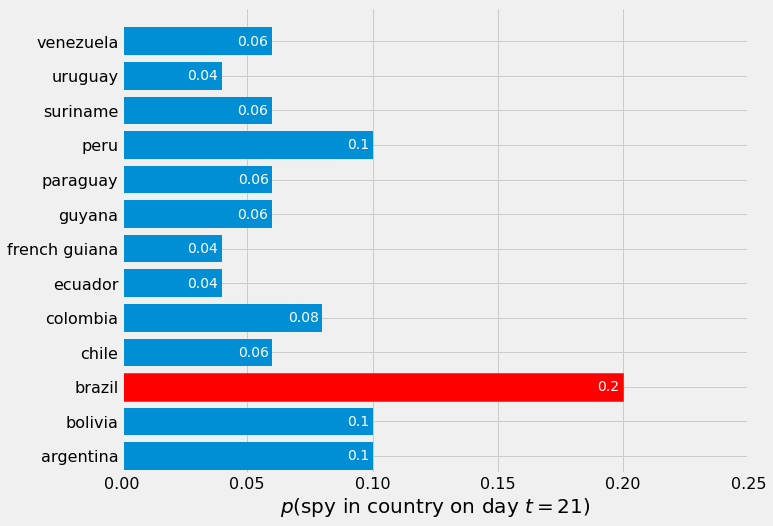

In [13]:
# TODO: make animated gif
plt.figure(figsize=(10, 8))
# calculate the probabilities for 3 weeks of wandering
probs = probability_vector(3 * 7)

# make a bar plot
pos = np.arange(len(countries))
rects = plt.barh(pos, probs)

# label the bars with their actual values
# see: http://matplotlib.org/examples/pylab_examples/barchart_demo2.html
for i, rect in enumerate(rects):
    plt.text(
        rect.get_width() - 0.0015,
        rect.get_y() + rect.get_height() / 2.0,
        str(round(probs[i], 4)),
        color="white",
        horizontalalignment="right",
        verticalalignment="center",
    )
rects[2].set_color("r")

# annotate the plot
plt.yticks(pos, countries, fontsize=16)
plt.xticks(fontsize=16)
plt.xlim(0, 0.25)
plt.ylim(-0.5, 13)
plt.xlabel(r"$p(\mathrm{spy\ in\ country\ on\ day\ }t=21)$", fontsize=20)
plt.show()

*Figure 4. Probability distribution of spy being in given country after 21 days.*

We might worry that we are not being exact here in interpreting "several weeks" as exactly $21$ days. What saves us is that this Markov chain converges to a steady state (called a stationary distribution) after a sufficient number of transitions.

For instance, here are the probabilities after different numbers of days:

In [14]:
initial_state = {0: probability_vector(0)}
comparison = pd.DataFrame(initial_state)

days = [1, 2, 3, 5, 10, 100, 1000]
for t in days:
    comparison[t] = probability_vector(t)
comparison.index.name = "day"
comparison.T.style.background_gradient(cmap="Blues", axis=1)

*Table 2. Probability of spy being in given country after arbitrary number of days: $1, 2, 3, 5, 10, 100$ and $1000$. Stationary distribution emerges after day $10$.*

It's pretty clear that, after a while, the probabilities converge to a steady state. Let's visualize this process. In the following graph, the x-axis will represent the number of transitions since the spy starts out in Chile on day $t=0$, and the y-axis will represent the probability of being in each country after that number of transitions.

(0.0, 0.4)

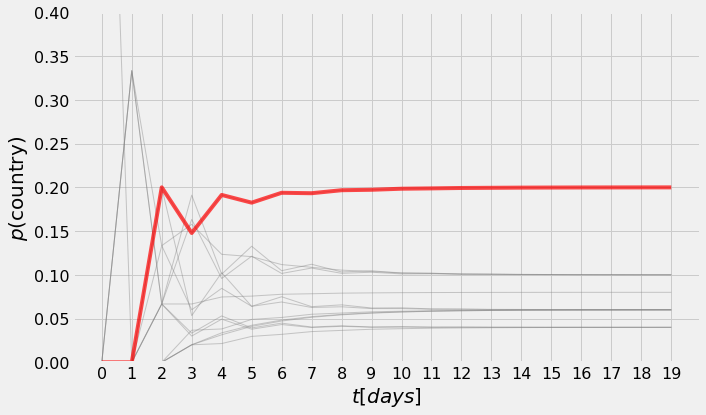

In [15]:
ts = np.arange(20)

for i, country in enumerate(countries):
    if i < 1:
        pm = np.array([probability_vector(t)[i] for t in ts])
    else:
        pv = np.array([probability_vector(t)[i] for t in ts])
        pm = np.vstack((pm, pv))

pm_df = pd.DataFrame(pm)

pm_df.T.plot(
    legend=False, figsize=(10, 6), marker="", color="grey", linewidth=1, alpha=0.4
)
# Now re-do the interesting curve, but bigger with distinct color
plt.plot(ts, pm_df.iloc[2, :], marker="", color="red", linewidth=4, alpha=0.7)

plt.xlabel("$t [days]$", fontsize=20)
plt.xticks(ts, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("$p(\mathrm{country})$", fontsize=20)
plt.ylim(0, 0.4)

*Figure 5. Evolution of probabilities that spy is being in given country at given day. Probabilities for Brasil is marked in orange other countries in red.*


The probabilities converge to the stationary distribution, with Brazil as the highest probability state at any given time. This should probably come as no surprise given that Brazil has the most adjacency with other nodes in this graph:

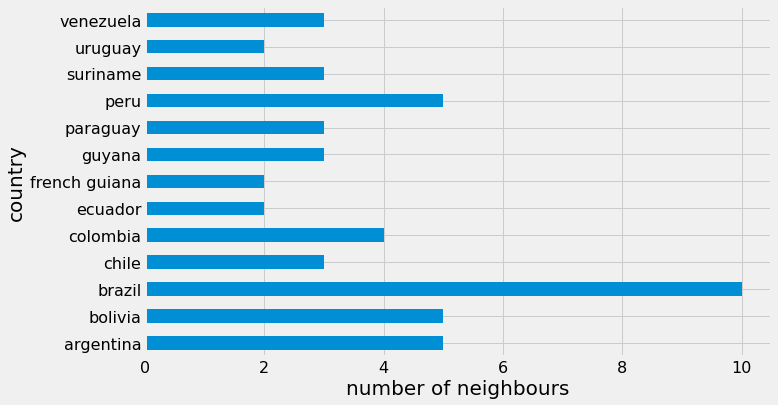

In [16]:
rects = pd.DataFrame(adjacency.sum(axis=1), index=countries).plot(
    kind="barh", figsize=(10, 6), legend=None, fontsize=16
)
plt.xlabel("number of neighbours", fontsize=20)
plt.ylabel("country", fontsize=20)
plt.show()

*Figure 6. Number of adjacent countries (neighbour count)*

With this data we can state that most probably the spy is on territory of Brasil  $p(Brazil)=0.2$ after several weeks hiding in South America countries.

In [17]:
# Ensure this cell has remove_input tag added (to hide it in blog post text)
from IPython.core.display import HTML

def css_styling():
    styles = open("../../styles/notebook_custom_style.css", "r").read()
    return HTML(styles)

css_styling()